# Code to train the RL agent

This code trains a PPO [stablebaseline3 RL-agent](https://github.com/DLR-RM/stable-baselines3) to learn an ideal policy to decide when to allow the student to use GenAI

## Imports

In [1]:
#imports 
from environment import LearningEnv     # your environment file
from gymnasium.envs.registration import register
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import psutil
psutil.virtual_memory()


STEP START — Current Task: 0 | Action taken: 0
Student did not answer in this iteration
Metatask: Task 1 | Last metatask: None
Time: 0 | Next try at: 157.78721422972905
Failed attempts on current task: 0
Failed attempts per metatask: {'Task 1': 0, 'Task 2': 0, 'Task 3': 0}
Used GenAI per metatask: {'Task 1': False, 'Task 2': False, 'Task 3': False}

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Reward for this action: -0.1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

STEP START — Current Task: 0 | Action taken: 0
Student did not answer in this iteration
Metatask: Task 1 | Last metatask: None
Time: 5 | Next try at: 157.78721422972905
Failed attempts on current task: 0
Failed attempts per metatask: {'Task 1': 0, 'Task 2': 0, 'Task 3': 0}
Used GenAI per metatask: {'Task 1': False, 'Task 2': False, 'Task 3': False}

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Reward for this action: -0.1
!!!!!!!!!!!!!!!!!!!!!!!

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


svmem(total=16952647680, available=8158994432, percent=51.9, used=8793653248, free=8158994432)

## 1. Register the custom environment

In [2]:
register(
    id="MyEnv-v0",
    entry_point="environment:LearningEnv",
)

## 2. Create and check the environment

In [3]:
env = gym.make("MyEnv-v0")
check_env(env)        #recommended by stable-baselines3 for custom envs
env = Monitor(env)    #logs rewards, episode lengths, etc.

## 3. Create PPO model

In [4]:
model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    tensorboard_log="./ppo_logs/",   # tensorboard --logdir ppo_logs
)

Using cpu device
Wrapping the env in a DummyVecEnv.


## 4. Train the model

In [5]:
#!tensorboard --logdir ppo_logs --port 6006

In [6]:
TIMESTEPS = 100_000
model.learn(total_timesteps=TIMESTEPS)

Logging to ./ppo_logs/PPO_16


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.22     |
|    ep_rew_mean     | -250     |
| time/              |          |
|    fps             | 1749     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.17        |
|    ep_rew_mean          | -244        |
| time/                   |             |
|    fps                  | 1253        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010578712 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | -0.00923    |
|    learning_rate        | 0.

## Print out a visual demonstration of the finally learned policy

The goal of this step is to make sure the environment does not simply always selects action 0

In [7]:
#Helper function to update a dictionary that keeps track of sums and counts for each position in lists
def update_position_sums(counter_dict, new_list):
    for i, val in enumerate(new_list):
        if i not in counter_dict:
            counter_dict[i] = [0, 0]  #[sum, count]
        counter_dict[i][0] += val
        counter_dict[i][1] += 1

Running episodes: 100%|██████████| 1000/1000 [01:15<00:00, 13.33it/s]


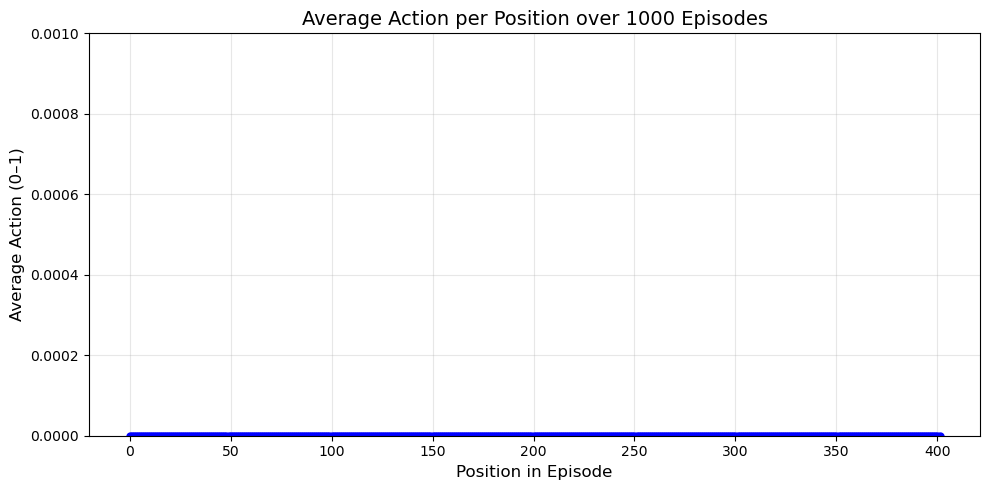

In [8]:
env = gym.make("MyEnv-v0")

num_episodes = 1000
action_means = {}

for ep in tqdm(range(num_episodes), desc="Running episodes"):
    obs, _ = env.reset()
    actions = []
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action)    # ensure it's 0 or 1
        obs, reward, terminated, truncated, info = env.step(action)
        if obs[1] > 4000:
            print(obs)
        done = terminated or truncated

    update_position_sums(action_means, actions)

# Calculate and print average actions per position
average_actions = {pos: sums[0] / sums[1] for pos, sums in action_means.items()}

# Sort positions to plot them in order
positions = sorted(average_actions.keys())
means = [average_actions[pos] for pos in positions]

plt.figure(figsize=(10,5))
plt.plot(positions, means, marker='o', linestyle='-', linewidth=2, markersize=5, color='blue')
plt.ylim(0, 1)  # actions are binary, so mean is between 0 and 1
plt.xlabel("Position in Episode", fontsize=12)
plt.ylim(0,0.001)
plt.ylabel("Average Action (0–1)", fontsize=12)
plt.title("Average Action per Position over 1000 Episodes", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

env.close()